# 🎓 Student Score Prediction

Predict students’ exam scores using study hours and other factors.
Tools: Python, Pandas, Matplotlib, Scikit-learn
Evaluation: MAE, MSE, RMSE, R²

## 📦 Step 1: Import Libraries


In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

### Methods to use later

In [2]:
def get_uniques(df, columns):
    return {column: list (df[column].unique()) for column in columns}

In [3]:
def get_categorical_columns(df):
    return [column for column in df.columns if df.dtypes[column] == 'object']

In [4]:
def fill_cols_with_nan(df):
    columns = get_categorical_columns(df)
    for column in columns:
        df[column] = df[column].fillna("Unknown")

In [5]:
def binary_encode(df, column, postive_value):
    df =  df.copy()
    df[column] = df[column].apply(lambda x: 1 if x == postive_value else 0)
    return df

In [6]:
def ordinal_encode(df, column, ordering):
    df =  df.copy()
    df[column] = df[column].apply(lambda x: ordering.index(x))
    return df

In [7]:
def onehot_encode(df, column, prefix):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df.drop(column, axis=1, inplace=True)
    return df

## 📂 Step 2: Load Dataset & Quick Overview


In [8]:
student_score_df = pd.read_csv("data/raw/StudentPerformanceFactors.csv")
student_score_df.head()

,Hours_Studied,Attendance,Parental_Involvement,Access_to_Resources,Extracurricular_Activities,Sleep_Hours,Previous_Scores,Motivation_Level,Internet_Access,Tutoring_Sessions,Family_Income,Teacher_Quality,School_Type,Peer_Influence,Physical_Activity,Learning_Disabilities,Parental_Education_Level,Distance_from_Home,Gender,Exam_Score
0,23,84,Low,High,No,7,73,Low,Yes,0,Low,Medium,Public,Positive,3,No,High School,Near,Male,67
1,19,64,Low,Medium,No,8,59,Low,Yes,2,Medium,Medium,Public,Negative,4,No,College,Moderate,Female,61
2,24,98,Medium,Medium,Yes,7,91,Medium,Yes,2,Medium,Medium,Public,Neutral,4,No,Postgraduate,Near,Male,74
3,29,89,Low,Medium,Yes,8,98,Medium,Yes,1,Medium,Medium,Public,Negative,4,No,High School,Moderate,Male,71
4,19,92,Medium,Medium,Yes,6,65,Medium,Yes,3,Medium,High,Public,Neutral,4,No,College,Near,Female,70


In [9]:
student_score_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              6607 non-null   obje

In [10]:
student_score_df.isna().sum()

Hours_Studied                  0
Attendance                     0
Parental_Involvement           0
Access_to_Resources            0
Extracurricular_Activities     0
Sleep_Hours                    0
Previous_Scores                0
Motivation_Level               0
Internet_Access                0
Tutoring_Sessions              0
Family_Income                  0
Teacher_Quality               78
School_Type                    0
Peer_Influence                 0
Physical_Activity              0
Learning_Disabilities          0
Parental_Education_Level      90
Distance_from_Home            67
Gender                         0
Exam_Score                     0
dtype: int64

## 📊 Step 3: Data Cleaning & Exploratory Data Analysis


In [11]:
get_uniques(student_score_df, get_categorical_columns(student_score_df))

{'Parental_Involvement': ['Low', 'Medium', 'High'],
 'Access_to_Resources': ['High', 'Medium', 'Low'],
 'Extracurricular_Activities': ['No', 'Yes'],
 'Motivation_Level': ['Low', 'Medium', 'High'],
 'Internet_Access': ['Yes', 'No'],
 'Family_Income': ['Low', 'Medium', 'High'],
 'Teacher_Quality': ['Medium', 'High', 'Low', nan],
 'School_Type': ['Public', 'Private'],
 'Peer_Influence': ['Positive', 'Negative', 'Neutral'],
 'Learning_Disabilities': ['No', 'Yes'],
 'Parental_Education_Level': ['High School', 'College', 'Postgraduate', nan],
 'Distance_from_Home': ['Near', 'Moderate', 'Far', nan],
 'Gender': ['Male', 'Female']}

In [12]:
binary_features = ['Extracurricular_Activities', 'Internet_Access', 'School_Type', 'Learning_Disabilities', 'Gender']

ordinal_features = ['Parental_Involvement', 'Access_to_Resources', 'Motivation_Level', 'Family_Income', 'Teacher_Quality',
                    'Parental_Education_Level', 'Distance_from_Home', 'Peer_Influence']

target_column = 'Exam_Score'


In [13]:
fill_cols_with_nan(student_score_df)
get_uniques(student_score_df, get_categorical_columns(student_score_df))

{'Parental_Involvement': ['Low', 'Medium', 'High'],
 'Access_to_Resources': ['High', 'Medium', 'Low'],
 'Extracurricular_Activities': ['No', 'Yes'],
 'Motivation_Level': ['Low', 'Medium', 'High'],
 'Internet_Access': ['Yes', 'No'],
 'Family_Income': ['Low', 'Medium', 'High'],
 'Teacher_Quality': ['Medium', 'High', 'Low', 'Unknown'],
 'School_Type': ['Public', 'Private'],
 'Peer_Influence': ['Positive', 'Negative', 'Neutral'],
 'Learning_Disabilities': ['No', 'Yes'],
 'Parental_Education_Level': ['High School',
  'College',
  'Postgraduate',
  'Unknown'],
 'Distance_from_Home': ['Near', 'Moderate', 'Far', 'Unknown'],
 'Gender': ['Male', 'Female']}

In [14]:
binary_positive_values = ['Yes', 'Yes', 'Private', 'Yes', 'Male']

ordinal_orderings = {
    'Parental_Involvement': ['Low', 'Medium', 'High'],
    'Access_to_Resources': ['Low', 'Medium', 'High'],
    'Motivation_Level': ['Low', 'Medium', 'High'],
    'Family_Income': ['Low', 'Medium', 'High'],
    'Teacher_Quality': ['Unknown', 'Low', 'Medium', 'High'],
    'Parental_Education_Level': ['Unknown', 'High School', 'College', 'Postgraduate'],
    'Distance_from_Home': ['Unknown', 'Near', 'Moderate', 'Far'],
    'Peer_Influence': ['Negative', 'Neutral', 'Positive']
}

In [15]:
for feature, positive_value in zip(binary_features, binary_positive_values):
    student_score_df = binary_encode(student_score_df, feature, positive_value)

In [16]:
for feature, ordering in ordinal_orderings.items():
    student_score_df = ordinal_encode(student_score_df, feature, ordering)

## ✂️ Step 4: Train-Test Split


In [17]:
y = student_score_df[target_column]
X = student_score_df.drop(target_column, axis=1)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=42)

In [19]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## 🤖 Step 5: Training


In [20]:
lin_reg = LinearRegression()

lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)

In [21]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Linear Regression Results:")
print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²:   {r2:.2f}")

Linear Regression Results:
MAE:  0.44
MSE:  3.29
RMSE: 1.81
R²:   0.77


In [22]:
cv_scores = cross_val_score(lin_reg, X, y, cv=5, scoring='r2')
print(f"Cross-Validated R² Scores: {cv_scores}")
print(f"Average R²: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

Cross-Validated R² Scores: [0.62444955 0.72270777 0.70876064 0.73198553 0.837785  ]
Average R²: 0.73 ± 0.07


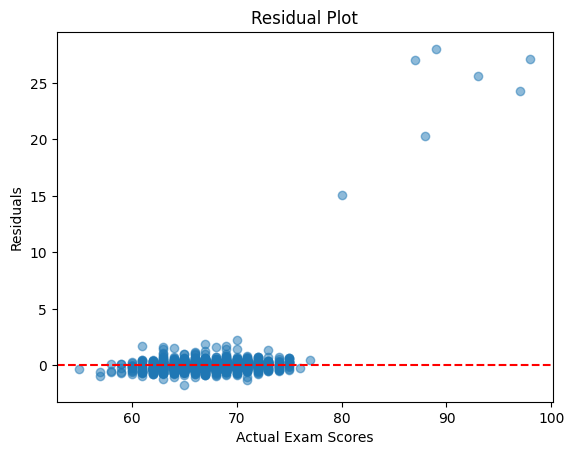

In [23]:
residuals = y_test - y_pred
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual Exam Scores')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()